In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
from ecoevocrm.consumer_resource_system import *
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg
import ecoevocrm.strain_pool

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

----

## Model parameters

### Traits

Set the number of resources in the system:

In [4]:
num_resources = 10

Define type(s) that will be present at the start of the simulation:

Here we define the initial population as consisting of only one type (which is the first type from the list of all possible types)

In [5]:
sigma_allpossible = utils.binary_combinations(num_resources, exclude_all_zeros=True)
sigma_allpossible = sigma_allpossible/sigma_allpossible.sum(axis=1, keepdims=1)

In [6]:
sigma = sigma_allpossible[0]

The initial composition of the population, as encoded in the $\sigma$ matrix, looks like this:

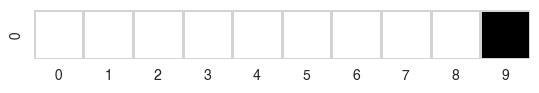

In [7]:
viz.matrix_plot(sigma, linecolor='lightgray', linewidths=1)

Set the initial abundance of each type:
    
(Here we set the initial abundance of each type to 1 individual)

In [8]:
N_init = np.ones(np.atleast_2d(sigma).shape[0])
N_init

array([1.])

### Costs

##### Define cost parameters for types:

Set the baseline cost $\xi$:

In [9]:
xi = 0.1

Set the cost per trait, $\chi_{i}$:

In [10]:
chi = 0.3
chi = [0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.4, 0.4, 0.4]

Set the trait interaction costs by defining a matrix, $\\J_{ij}$, that encodes the cost for each pair of traits:

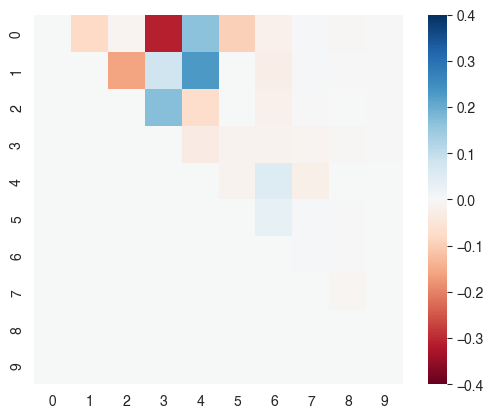

In [11]:
# J = None
J = utils.random_matrix((num_resources, num_resources), 'tikhonov_sigmoid', args={'n_star': 5, 'delta': 1}, triangular=True, diagonal=0, 
                        seed=2)
viz.matrix_plot(J, vmin=-0.4, vmax=0.4)

### Environment

Set the initial amount of each resource:

(Here the last 5 resources are present, while the first 5 resources are absent initially)

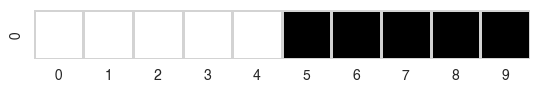

In [12]:
R_init = np.zeros(num_resources)
R_init[-5:] = 1
viz.matrix_plot(R_init, linecolor='lightgray', linewidths=1)

Set the influx of each resource:

(Here the last 5 resources have influx, while the first 5 resources have zero influx)

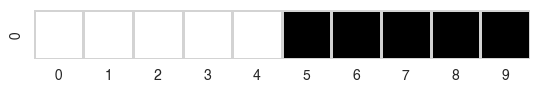

In [13]:
rho = np.zeros(num_resources)
rho[-5:] = 1
viz.matrix_plot(rho, linecolor='lightgray', linewidths=1)

Set the time constant for resource dynamics (will be 1 in practically all cases)

In [14]:
tau = 1

Set the resource dynamics mode used in the simulation. 

(Since we are doing crossfeeding here, we must use 'explicit' resource dynamcis)

In [30]:
resource_dynamics_mode='explicit'

### Cross-feeding

Set the energy content for each resource (will typically be 1)

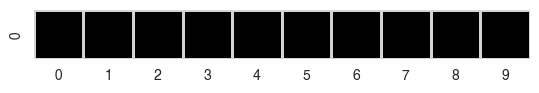

In [15]:
omega = np.ones(num_resources)
viz.matrix_plot(omega, vmin=0, vmax=1, linecolor='lightgray', linewidths=1)

Set the fraction of energy from each resource that is converted into other resource byproducts (rather than used for growth)

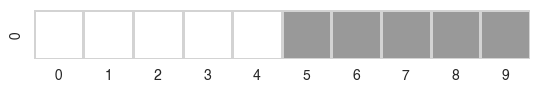

In [16]:
lamda = np.zeros(num_resources)
lamda[5:] = 0.49
viz.matrix_plot(lamda, vmin=0, vmax=1, cbar=False, linecolor='lightgray', linewidths=1)

Define which resources are converted into which other resources (as byproducts) by defining a matrix $D_{ij}$, where each entry $i,j$ gives the fraction of byproducts of resource $j$ that are converted to resource $i$ (i.e., $i \leftarrow j$). 

Here each of the last 5 resources gets converted to one of the first 5 resources.

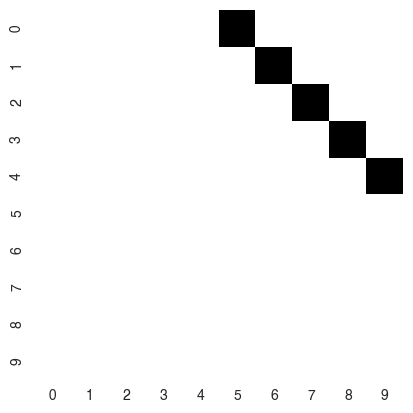

In [17]:
D = utils.random_matrix((num_resources, num_resources), 'binomial', args={'p': 0.0}, diagonal=0)
D += np.diag(np.array([1]*5), 5)
viz.matrix_plot(D, vmin=0, vmax=1)

## Simulate model

In [18]:
system = ConsumerResourceSystem(type_set=TypeSet(sigma=sigma, lamda=lamda, xi=xi, chi=chi, J=J, binarize_traits_J_cost_terms=True, mu=1e-10), 
                                rho=rho, tau=tau, omega=omega, D=D,
                                N_init=N_init, R_init=R_init, 
                                resource_dynamics_mode=resource_dynamics_mode, 
                                max_time_step=1e3)

In [19]:
T_total = 1e6

In [20]:
system.run(T=T_total)

<AxesSubplot: >

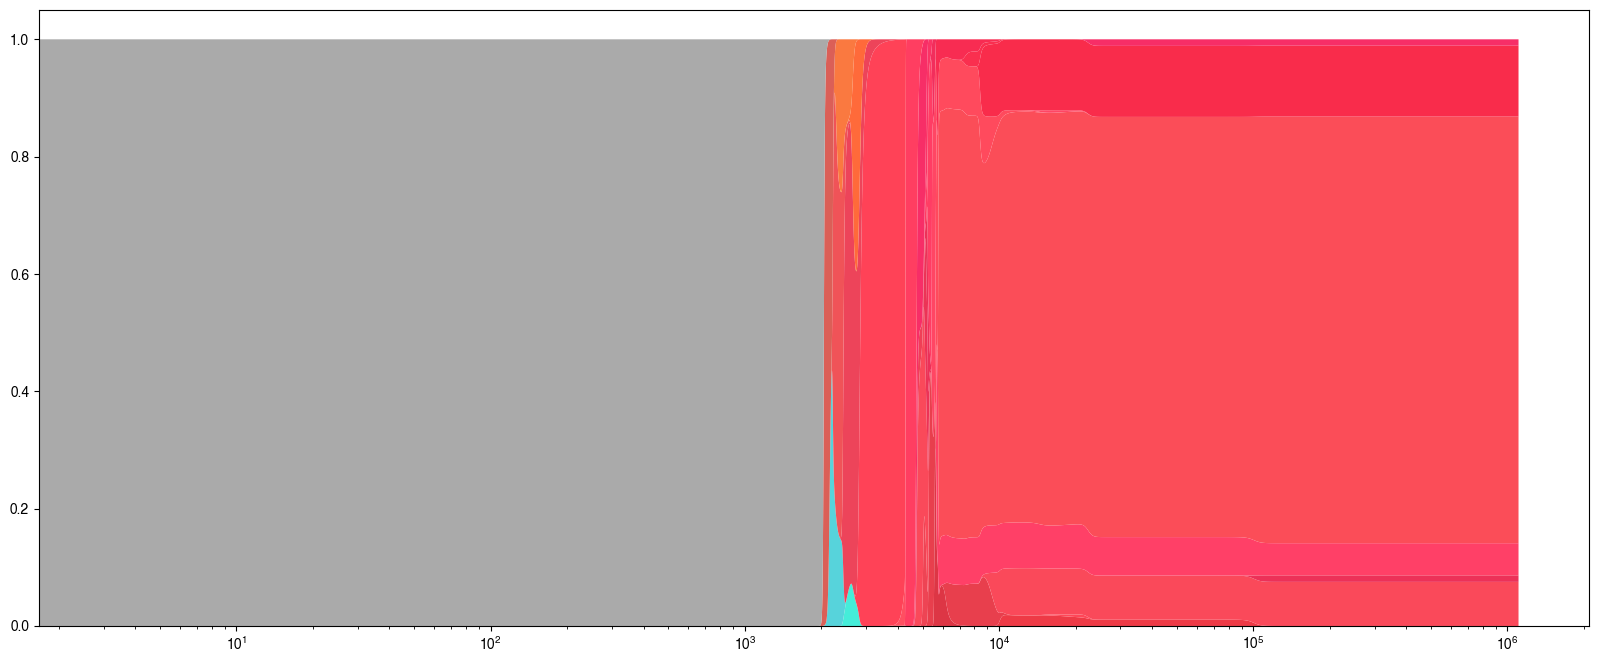

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(system, ax=ax, relative_abundance=True, apply_palette_depth=1, log_x_axis=True, color_seed=1)

<AxesSubplot: >

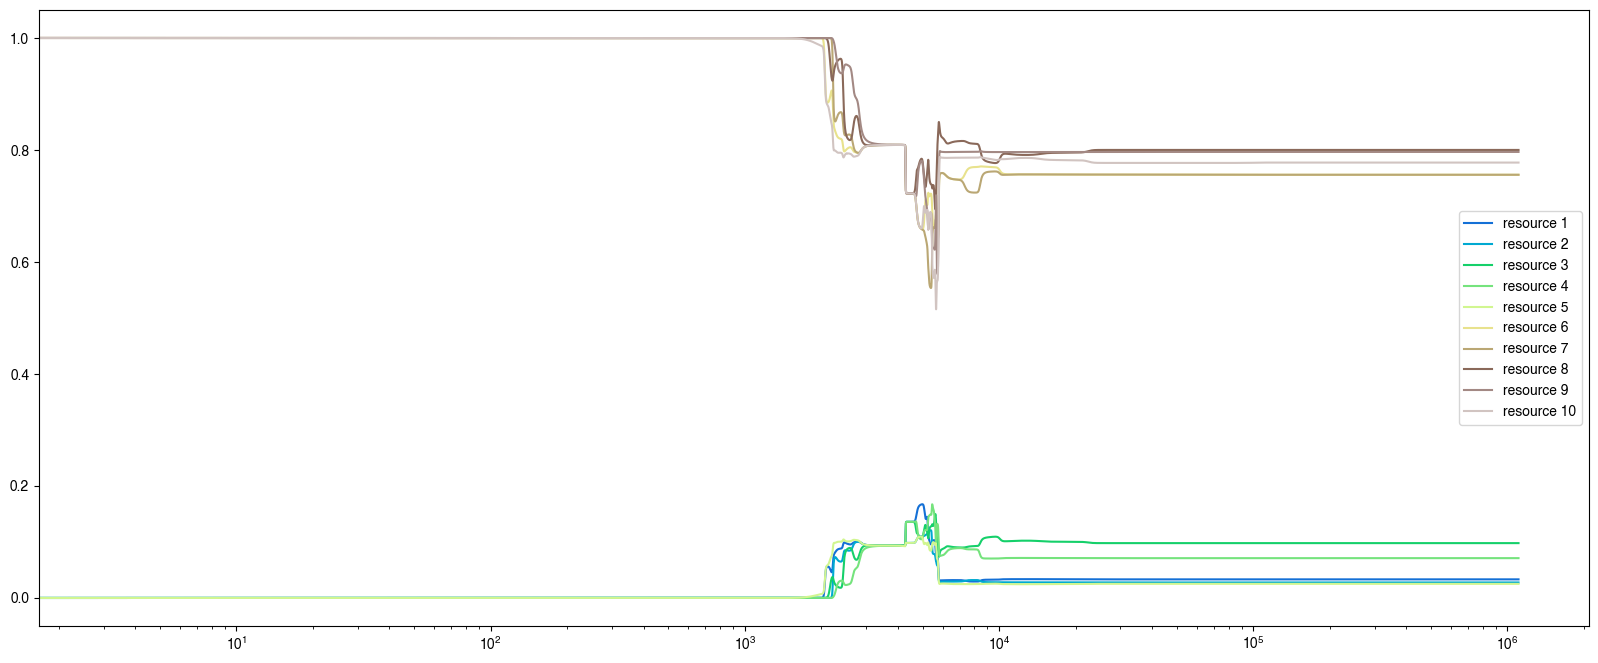

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.resource_plot(system, ax=ax, stacked=False, relative=False, log_x_axis=True, log_y_axis=False)

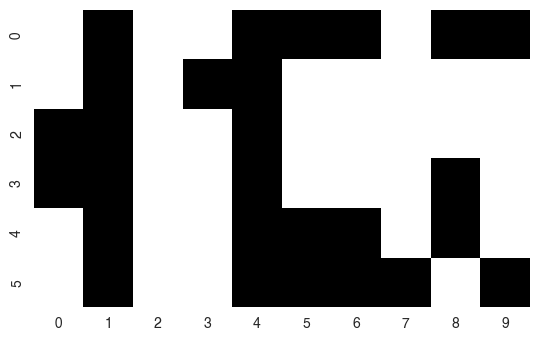

In [28]:
viz.matrix_plot(system.extant_type_set.sigma)

In [24]:
# with np.printoptions(threshold=np.inf):
#     for tidx in range(system.N_series.shape[1])[::-1]:
#         print(system.N_series[:, tidx])
#         # print(np.max(system.N_series[:, tidx]))

---------
---------